Loading and Merging

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


Loading preprocessed data:

In [102]:
# loading X_train, X_test, y_train, y_test
X = pd.read_csv('data/X.csv')
y = pd.read_csv('data/y.csv')

In [103]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76822 entries, 0 to 76821
Columns: 495 entries, age to job_end_2019
dtypes: bool(259), float64(236)
memory usage: 157.3 MB



EDA label variable

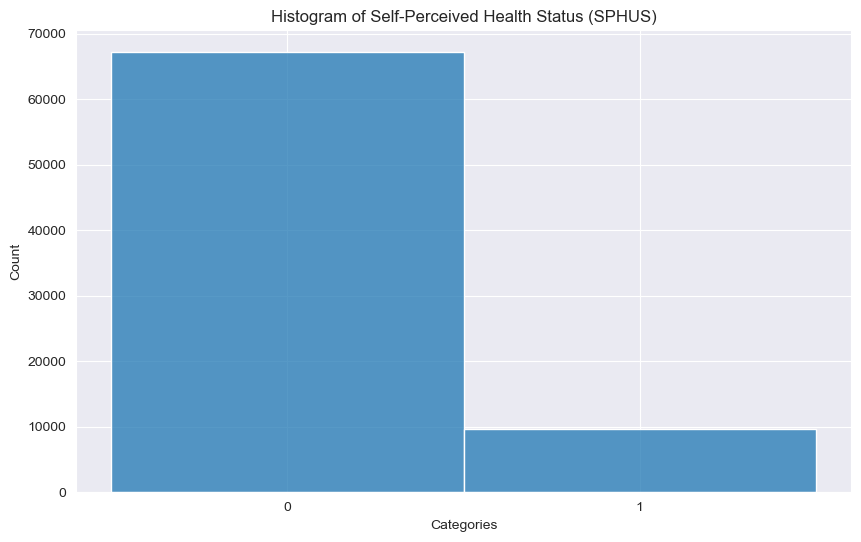

In [104]:
# histo
plt.figure(figsize=(10, 6))
sns.histplot(y['sphus'], discrete=True)
plt.title('Histogram of Self-Perceived Health Status (SPHUS)')
plt.xlabel('Categories')
plt.xticks([0, 1])
plt.show()

Grouped Feature Selection

In [105]:
variable_names = X.columns.tolist()

# Initialize lists for each category
temperature_vars = []
radiation_vars = []
precipitation_vars = []
pollution_vars = {'PM2.5': [], 'PM10': [], 'NO2': [], 'O3': []}
flood_vars = []
heating_cooling_vars = []  # For Heating Degree Days (HDD) and Cooling Degree Days (CDD)

for var in variable_names:
    # Temperature variables
    if 'tn_' in var or 'tg_' in var or 'tx_' in var:
        temperature_vars.append(var)
    
    # Radiation variables
    elif 'radiation' in var:
        radiation_vars.append(var)
    
    # Precipitation variables
    elif 'prec' in var:
        precipitation_vars.append(var)
    
    # Pollution variables
    elif 'pm2p5' in var or 'conc_pm2p5' in var:
        pollution_vars['PM2.5'].append(var)
    elif 'pm10' in var or 'conc_pm10' in var:
        pollution_vars['PM10'].append(var)
    elif 'no2' in var or 'conc_no2' in var:
        pollution_vars['NO2'].append(var)
    elif 'o3' in var or 'conc_o3' in var:
        pollution_vars['O3'].append(var)
    
    # Flood variables
    elif 'fl_' in var:
        flood_vars.append(var)
    
    # Heating and Cooling Degree Days
    elif 'HDD' in var or 'CDD' in var:
        heating_cooling_vars.append(var)

In [106]:
feature_groups = {
    'temperature': temperature_vars,
    'radiation': radiation_vars,
    'precipitation': precipitation_vars,
    'pollution_PM2.5': pollution_vars['PM2.5'],
    'pollution_PM10': pollution_vars['PM10'],
    'pollution_NO2': pollution_vars['NO2'],
    'pollution_O3': pollution_vars['O3'],
    'floods': flood_vars,
    'heating_cooling': heating_cooling_vars
}

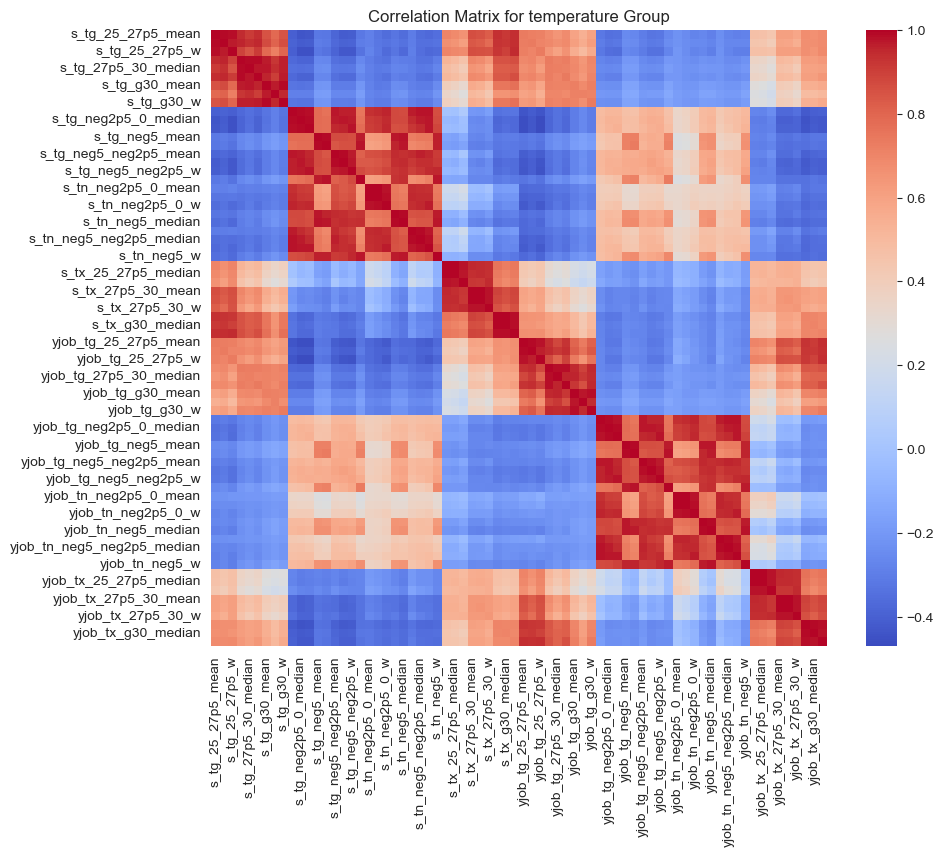

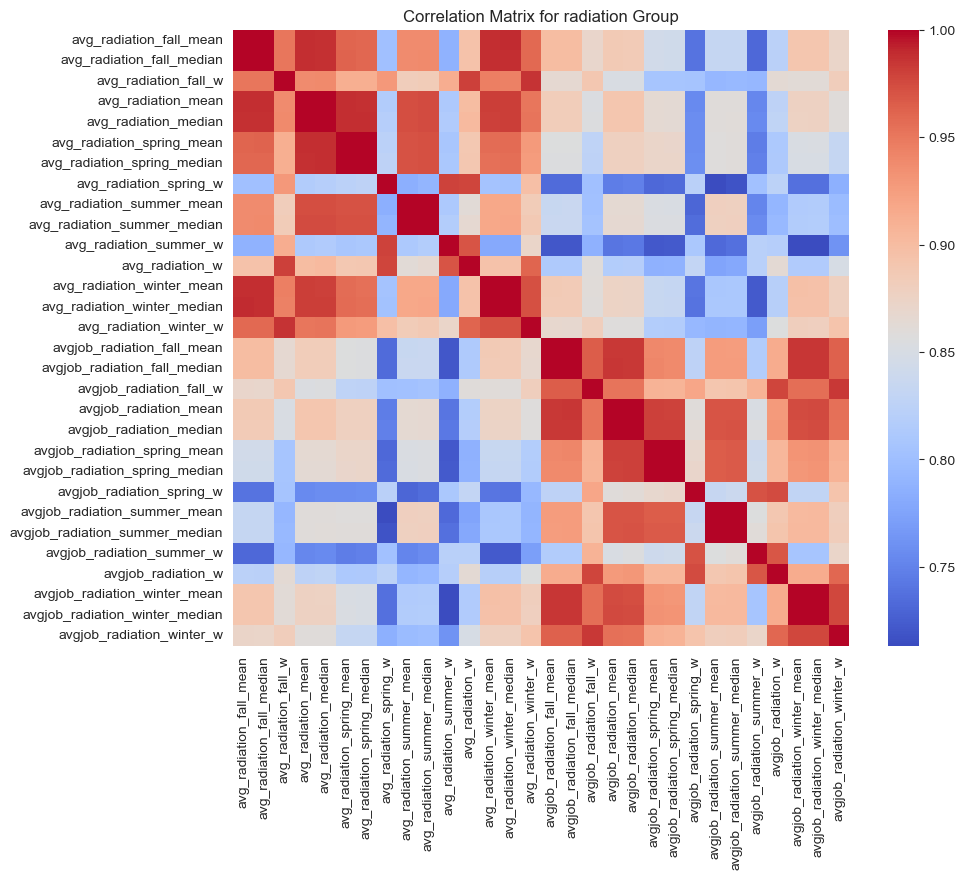

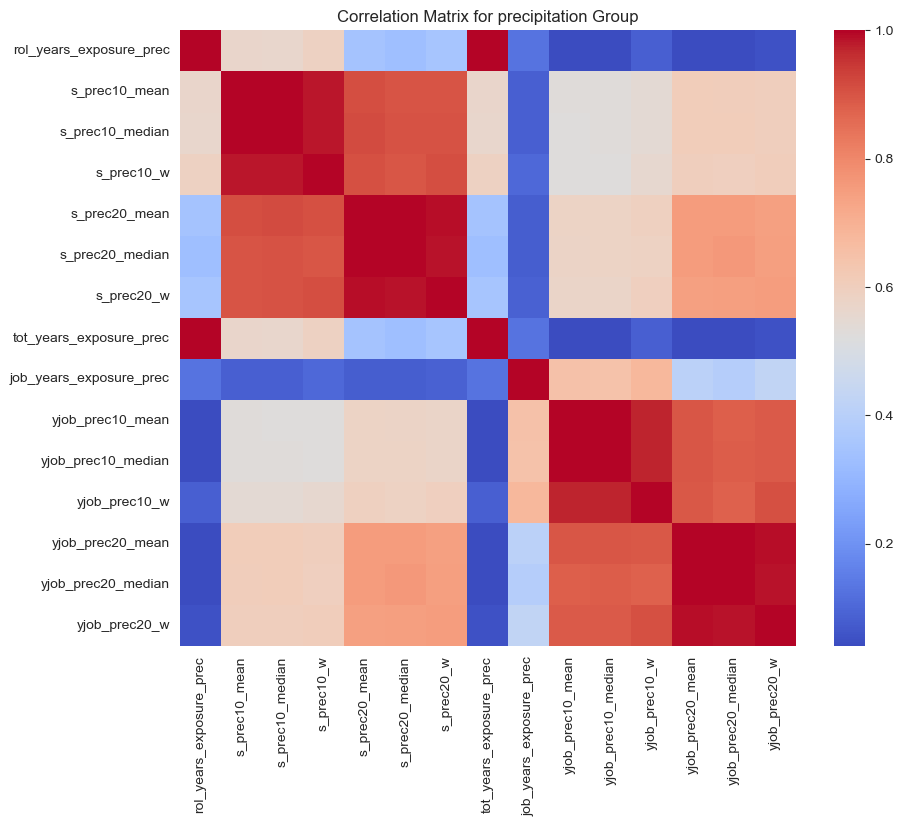

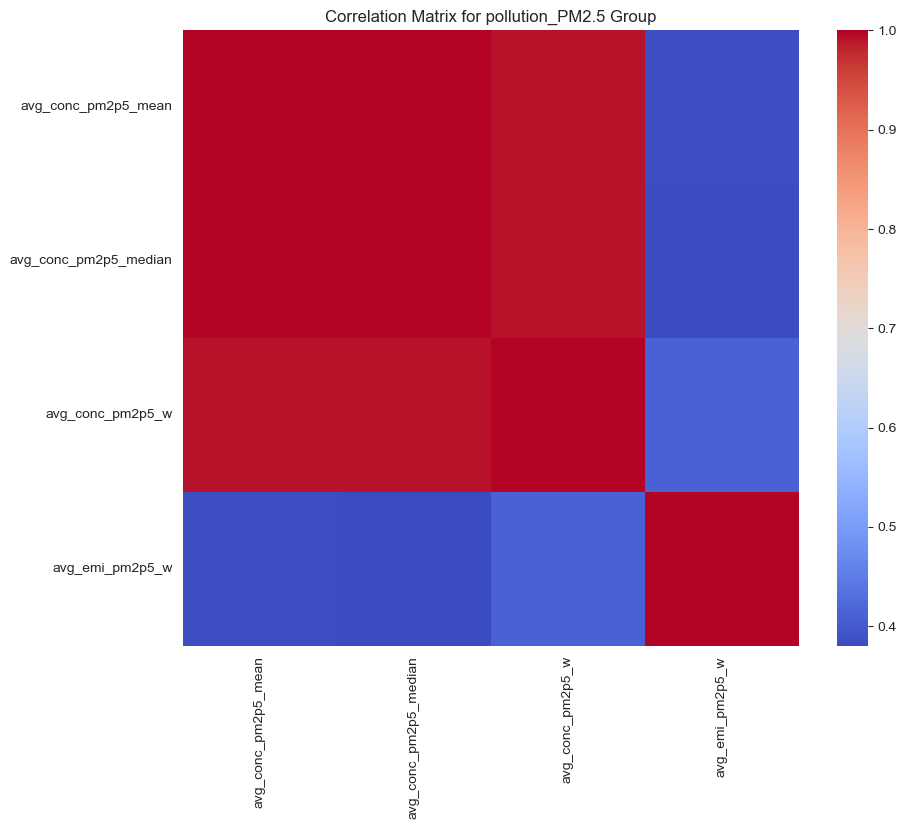

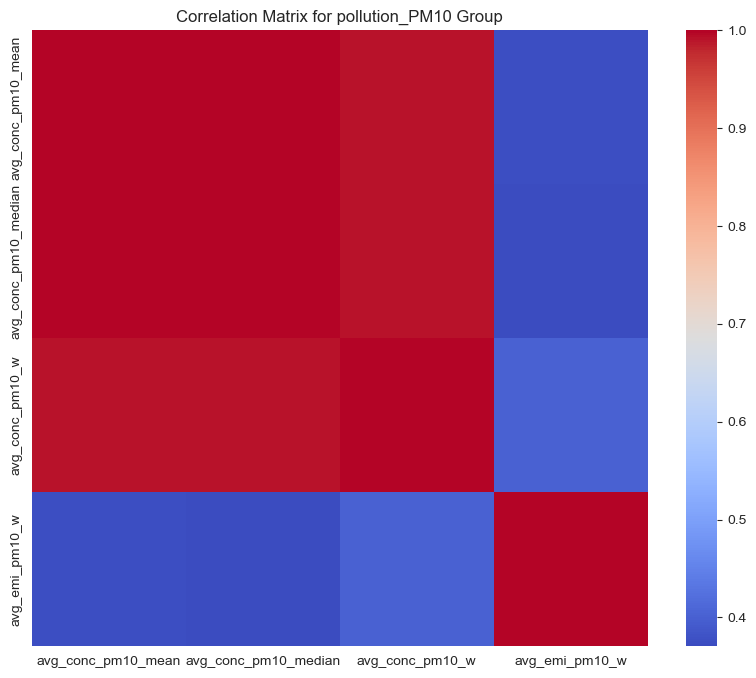

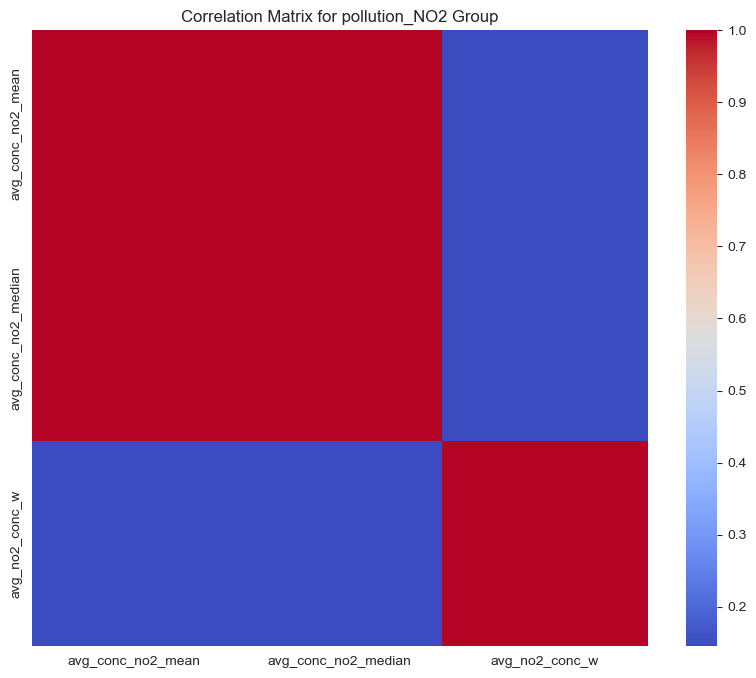

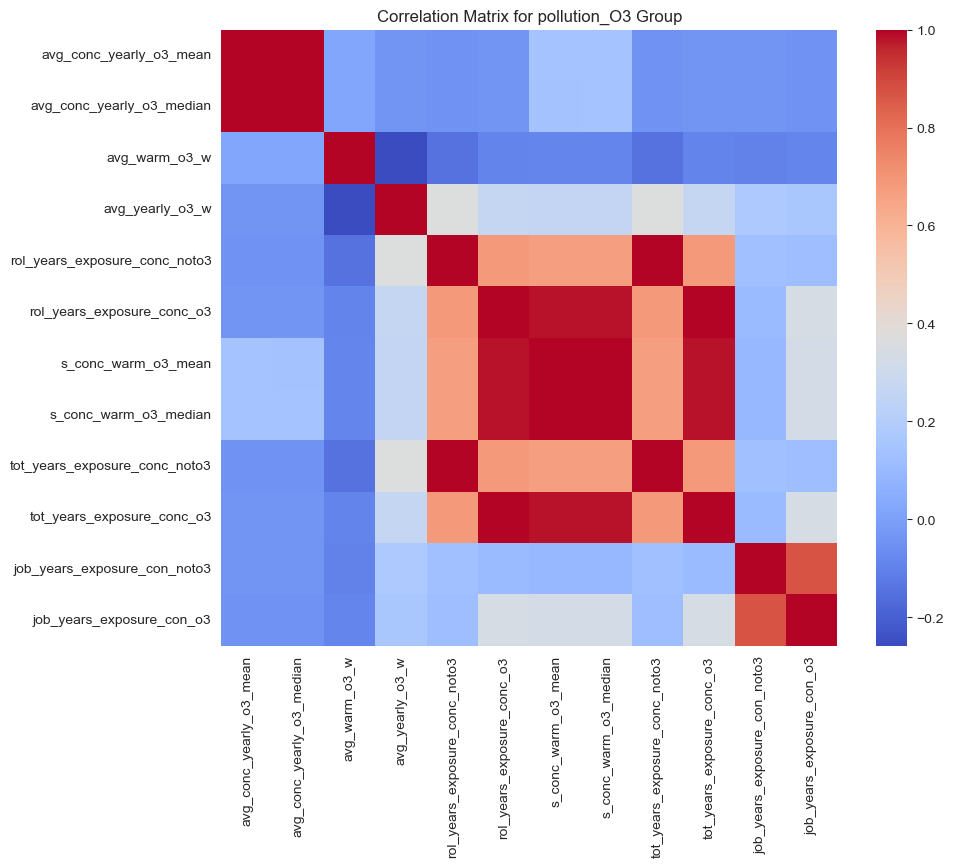

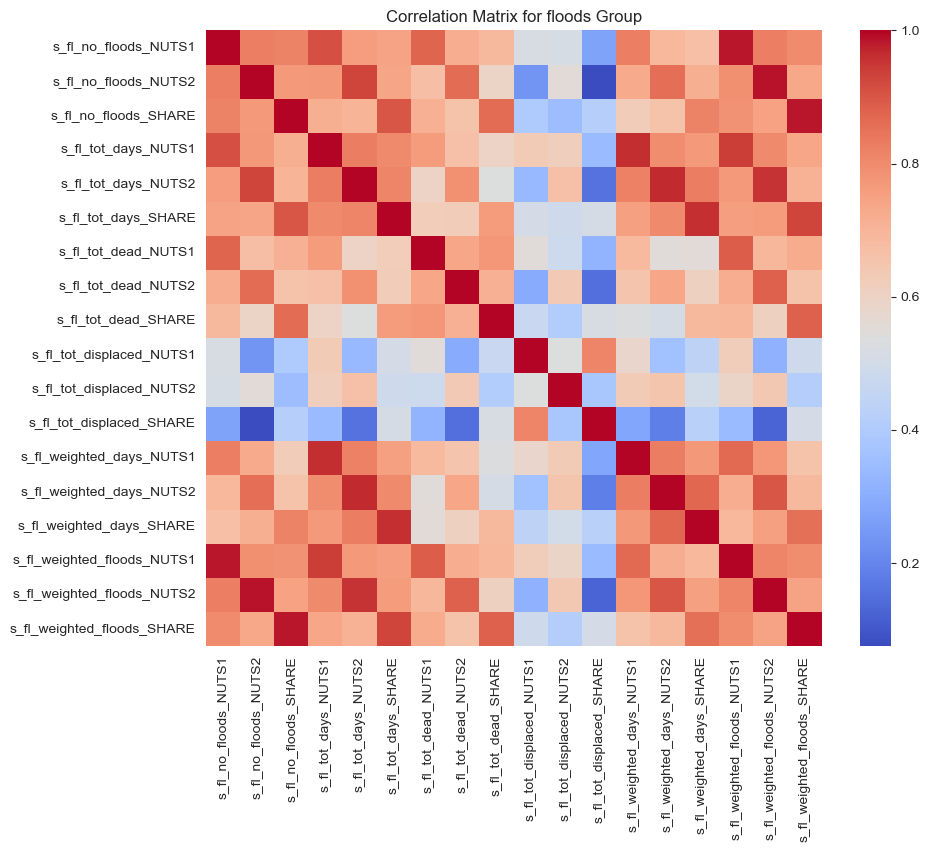

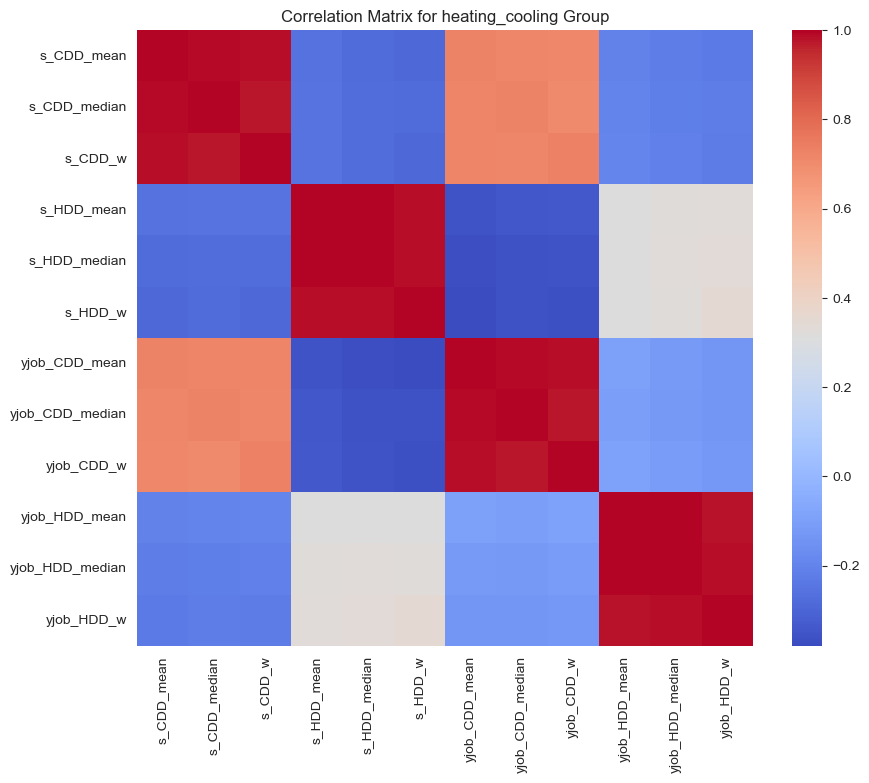

In [107]:
for group_name, features in feature_groups.items():
    # Filter the DataFrame to keep only the current group's features
    df_group = X[features]
    
    # Calculate the correlation matrix
    corr_matrix = df_group.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title(f'Correlation Matrix for {group_name} Group')
    plt.show()

Split the data

In [108]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Imputing categorical with most frequent and doing one hot encoding:

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)

# Dictionary to store the top three most important features by group
best_features = {}

# Iterate over each feature group to identify the top three important features
for group_name, features in feature_groups.items():
    # Ensure the feature group is not empty and contains valid features
    if not features:
        continue
    
    # Select the current group's features from the scaled training data
    valid_features = X_train.columns.intersection(features)

    if valid_features.empty:
        print(f"{group_name}: No valid features after data preparation.")
        continue

    # Train the Random Forest model on the selected features
    rf_model.fit(X_train[valid_features], y_train)

    # Get the feature importances and find the three most important ones
    importances = rf_model.feature_importances_
    top_three_indices = np.argsort(importances)[-3:]  # Get indices of the top three features
    top_three_features = valid_features[top_three_indices]
    best_features[group_name] = top_three_features

    # Evaluate the model's performance on the test data
    predictions = rf_model.predict(X_test[valid_features])
    accuracy = accuracy_score(y_test, predictions)
    print(f"{group_name} - Top 3 Important Features: {top_three_features.tolist()}, Accuracy: {accuracy:.4f}")

# Output the best features from each group
print("Best Features by Group:", best_features)


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


temperature - Top 3 Important Features: ['s_tg_neg2p5_0_w', 's_tx_25_27p5_mean', 's_tx_25_27p5_w'], Accuracy: 0.8713


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


radiation - Top 3 Important Features: ['avgjob_radiation_fall_mean', 'avgjob_radiation_winter_median', 'avgjob_radiation_spring_w'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


precipitation - Top 3 Important Features: ['s_prec20_w', 'tot_years_exposure_prec', 'rol_years_exposure_prec'], Accuracy: 0.8717
pollution_PM2.5 - Top 3 Important Features: ['avg_emi_pm2p5_w', 'avg_conc_pm2p5_mean', 'avg_conc_pm2p5_w'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_PM10 - Top 3 Important Features: ['avg_emi_pm10_w', 'avg_conc_pm10_median', 'avg_conc_pm10_w'], Accuracy: 0.8717
pollution_NO2 - Top 3 Important Features: ['avg_no2_conc_w', 'avg_conc_no2_mean', 'avg_conc_no2_median'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_O3 - Top 3 Important Features: ['rol_years_exposure_conc_noto3', 'job_years_exposure_con_noto3', 'job_years_exposure_con_o3'], Accuracy: 0.8717
floods - Top 3 Important Features: ['s_fl_tot_dead_NUTS1', 's_fl_tot_displaced_SHARE', 's_fl_weighted_days_SHARE'], Accuracy: 0.8717


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


heating_cooling - Top 3 Important Features: ['s_CDD_mean', 's_HDD_w', 's_HDD_median'], Accuracy: 0.8716
Best Features by Group: {'temperature': Index(['s_tg_neg2p5_0_w', 's_tx_25_27p5_mean', 's_tx_25_27p5_w'], dtype='object'), 'radiation': Index(['avgjob_radiation_fall_mean', 'avgjob_radiation_winter_median',
       'avgjob_radiation_spring_w'],
      dtype='object'), 'precipitation': Index(['s_prec20_w', 'tot_years_exposure_prec', 'rol_years_exposure_prec'], dtype='object'), 'pollution_PM2.5': Index(['avg_emi_pm2p5_w', 'avg_conc_pm2p5_mean', 'avg_conc_pm2p5_w'], dtype='object'), 'pollution_PM10': Index(['avg_emi_pm10_w', 'avg_conc_pm10_median', 'avg_conc_pm10_w'], dtype='object'), 'pollution_NO2': Index(['avg_no2_conc_w', 'avg_conc_no2_mean', 'avg_conc_no2_median'], dtype='object'), 'pollution_O3': Index(['rol_years_exposure_conc_noto3', 'job_years_exposure_con_noto3',
       'job_years_exposure_con_o3'],
      dtype='object'), 'floods': Index(['s_fl_tot_dead_NUTS1', 's_fl_tot_displac

In [110]:
# Step 1: Flatten the list of best features and convert to a set for faster lookup
best_features_set = set(feature for feature_list in best_features.values() for feature in feature_list)

# Step 2: Initialize a list to hold variables to drop
vars_to_drop = []

# Step 3: Identify variables to drop from each feature group
for group_name, features in feature_groups.items():
    vars_to_drop.extend([var for var in features if var not in best_features_set])

# Step 4: Drop these unwanted variables from the scaled DataFrames
X_train_selected = X_train.drop(columns=vars_to_drop, errors='ignore')
X_test_selected = X_test.drop(columns=vars_to_drop, errors='ignore')

# Step 5: Output the shape of original and modified DataFrames to check consistency
print("Original X_train shape:", X_train.shape)
print("Modified X_train shape:", X_train_selected.shape)
print("Original X_test shape:", X_test.shape)
print("Modified X_test shape:", X_test_selected.shape)


Original X_train shape: (61457, 495)
Modified X_train shape: (61457, 352)
Original X_test shape: (15365, 495)
Modified X_test shape: (15365, 352)


In [111]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=100000)

# Train the model on the selected features
log_reg_model.fit(X_train, y_train)

# Make predictions on the test data
simple_y_pred = log_reg_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, simple_y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Model Accuracy: 0.9037


In [112]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

model = LogisticRegression()
param_grid = {
    'C': [1],
    'penalty': ['l2', 'l1'],  # l2 seems to have better performance (elasticnet is taking too long to converge)
    'max_iter': [100000],
    'solver': ['lbfgs', 'liblinear'],
    'l1_ratio': [0.5]    
}
full_grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
full_grid_search.fit(X_train, y_train)
print("Best parameters:", full_grid_search.best_params_)
print("Best score:", full_grid_search.best_score_)
full_y_pred = full_grid_search.predict(X_test)

accuracy = accuracy_score(y_test, full_y_pred)
print(f"Full Logistic Regression Model Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/pytho

Best parameters: {'C': 1, 'l1_ratio': 0.5, 'max_iter': 100000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.9039165991068684
Full Logistic Regression Model Accuracy: 0.9037


In [113]:
model = LogisticRegression()
param_grid = {
    'C': [1, 10],
    'penalty': ['l2', 'l1'],  # l2 seems to have better performance (elasticnet is taking too long to converge)
    'max_iter': [100000],
    'solver': ['lbfgs', 'liblinear'],    
}
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
y_pred = grid_search.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A 

Best parameters: {'C': 1, 'max_iter': 100000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.9042583006415924
Logistic Regression Model Accuracy: 0.9028


ROC-AUC Score: 0.9068


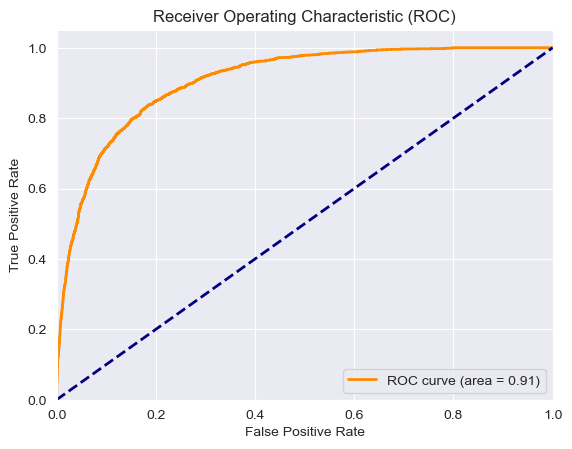

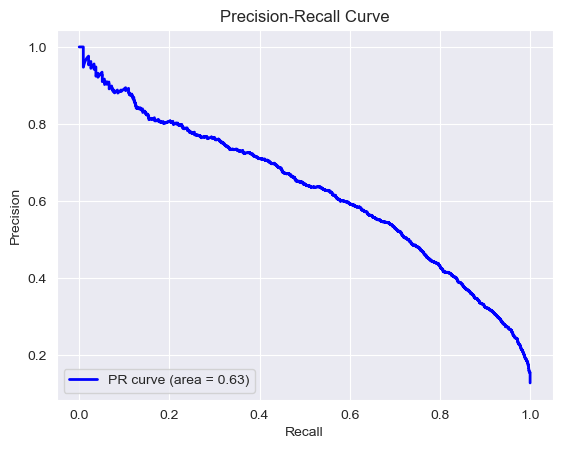

In [114]:
y_pred_proba = grid_search.predict_proba(X_test_selected)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

RF

In [115]:
# Initialize a new RandomForestClassifier
rf_top_grouped = RandomForestClassifier(random_state=42)

# Fit the RandomForest model on the selected and scaled training data
rf_top_grouped.fit(X_train_selected, y_train)

# Get the parameters of the fitted RandomForestClassifier instance
rf_grouped_parameters = rf_top_grouped.get_params()

# Display each parameter and its value
print("Parameters of the RandomForestClassifier:")
for param, value in rf_grouped_parameters.items():
    print(f"The parameter '{param}' is set to {value}.")

/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Parameters of the RandomForestClassifier:
The parameter 'bootstrap' is set to True.
The parameter 'ccp_alpha' is set to 0.0.
The parameter 'class_weight' is set to None.
The parameter 'criterion' is set to gini.
The parameter 'max_depth' is set to None.
The parameter 'max_features' is set to sqrt.
The parameter 'max_leaf_nodes' is set to None.
The parameter 'max_samples' is set to None.
The parameter 'min_impurity_decrease' is set to 0.0.
The parameter 'min_samples_leaf' is set to 1.
The parameter 'min_samples_split' is set to 2.
The parameter 'min_weight_fraction_leaf' is set to 0.0.
The parameter 'monotonic_cst' is set to None.
The parameter 'n_estimators' is set to 100.
The parameter 'n_jobs' is set to None.
The parameter 'oob_score' is set to False.
The parameter 'random_state' is set to 42.
The parameter 'verbose' is set to 0.
The parameter 'warm_start' is set to False.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column

ROC-AUC Score: 0.9018


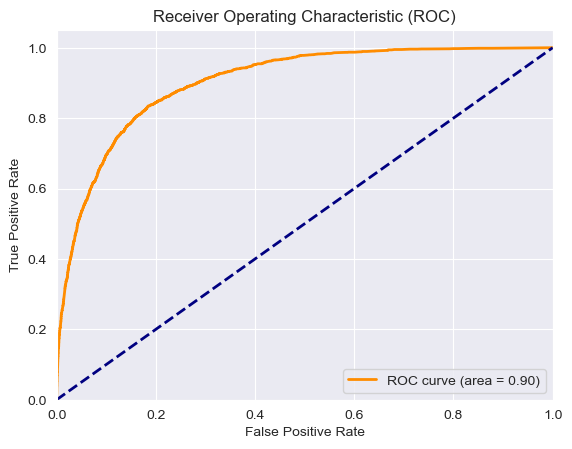

In [116]:
# Ensure necessary imports are included
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV

# Apply the same preprocessing steps to the test set
X_train_selected = X_train[X_train_selected.columns]
X_test_selected = X_test[X_train_selected.columns]

# Initialize a new RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],  # Simplified for speed
    'max_depth': [None, 5, 10, 20],   # Reduced options
    'min_samples_split': [2, 4, 8]  # Default and one variation
}

# Perform grid search with cross-validation
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)


cv_rf.fit(X_train_selected, y_train)

y_pred_proba = cv_rf.predict_proba(X_test_selected)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



In [117]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
print(f"Logistic Regression Model Report wth hyperparameter tuning and dropped grouped features:\n {classification_report(y_test, y_pred)}")
print(f"Logistic Regression Model Report wth hyperparameter tuning:\n {classification_report(y_test, full_y_pred)}")
print(f"Random Forest Model Report wth hyperparameter tuning and dropped grouped features:\n {classification_report(y_test, cv_rf.predict(X_test_selected))}")

Logistic Regression Model Report wth hyperparameter tuning and dropped grouped features:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     13393
           1       0.69      0.44      0.54      1972

    accuracy                           0.90     15365
   macro avg       0.81      0.71      0.74     15365
weighted avg       0.89      0.90      0.89     15365

Logistic Regression Model Report wth hyperparameter tuning:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     13393
           1       0.69      0.45      0.54      1972

    accuracy                           0.90     15365
   macro avg       0.81      0.71      0.75     15365
weighted avg       0.89      0.90      0.89     15365
Random Forest Model Report wth hyperparameter tuning and dropped grouped features:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     13393
   

Adjusting Class Weights
LogReg

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A 

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90     13393
           1       0.43      0.80      0.56      1972

    accuracy                           0.84     15365
   macro avg       0.70      0.82      0.73     15365
weighted avg       0.90      0.84      0.86     15365

ROC-AUC Score: 0.9084
Precision-Recall AUC Score: 0.6252


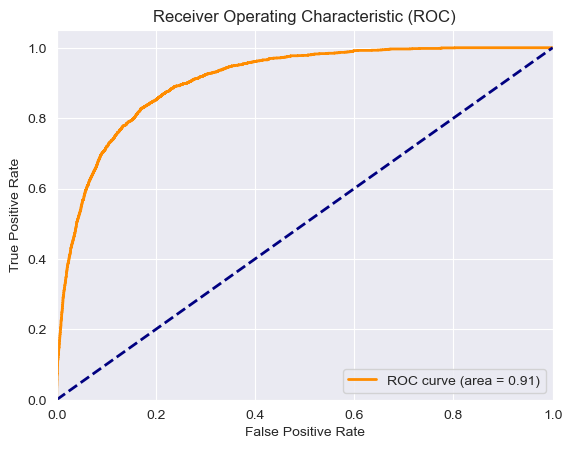

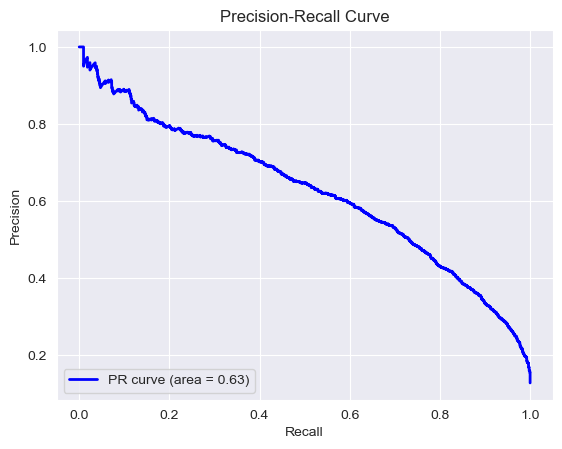

Best parameters found by GridSearchCV:
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Recall for class 1: 0.8007


In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, precision_recall_curve, recall_score

# Ensure necessary imports
import matplotlib.pyplot as plt

# Initialize the Logistic Regression model with class_weight='balanced'
log_reg_model = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=log_reg_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = grid_search.predict(X_test_selected)
y_pred_proba = grid_search.predict_proba(X_test_selected)[:, 1]

# Calculate and print classification report
report = classification_report(y_test, y_pred, output_dict=True)
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calculate Precision-Recall curve and AUC score
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print the recall score for class 1
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall for class 1: {recall_class_1:.4f}")


Balanced RF

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     13393
           1       0.63      0.43      0.52      1972

    accuracy                           0.90     15365
   macro avg       0.78      0.70      0.73     15365
weighted avg       0.88      0.90      0.89     15365

ROC-AUC Score: 0.9004
Precision-Recall AUC Score: 0.6013


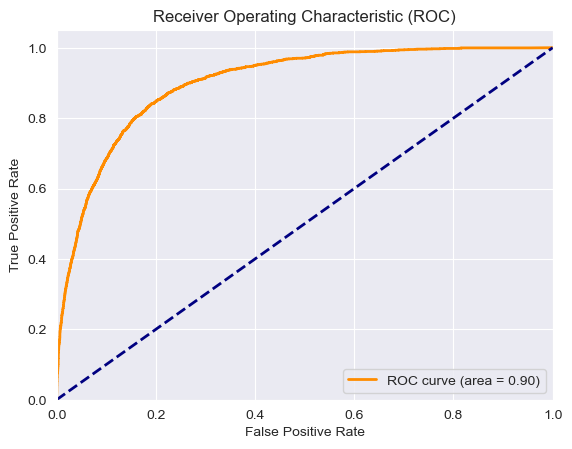

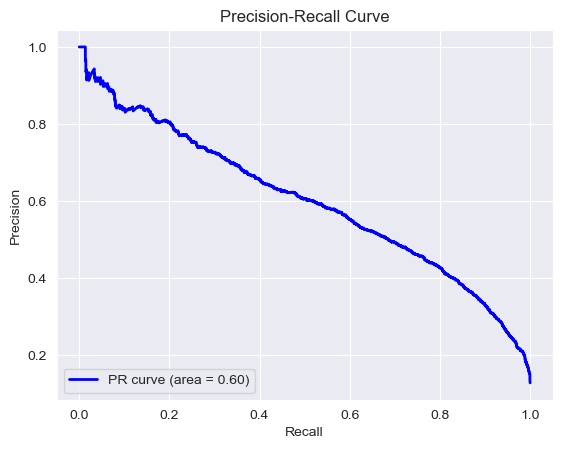

Best parameters found by GridSearchCV:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Recall for class 1: 0.4341


In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, recall_score
import matplotlib.pyplot as plt

# Ensure necessary imports
import matplotlib.pyplot as plt

# Flatten y_train and y_test to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Initialize the Random Forest model with class_weight='balanced'
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf = grid_search_rf.predict(X_test_selected)
y_pred_proba_rf = grid_search_rf.predict_proba(X_test_selected)[:, 1]

# Calculate and print classification report
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
print(f"Classification Report:\n {classification_report(y_test, y_pred_rf)}")

# Calculate ROC curve and AUC score
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")

# Calculate Precision-Recall curve and AUC score
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)
print(f"Precision-Recall AUC Score: {pr_auc_rf:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label=f'PR curve (area = {pr_auc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search_rf.best_params_)

# Print the recall score for class 1
recall_class_1_rf = recall_score(y_test, y_pred_rf, pos_label=1)
print(f"Recall for class 1: {recall_class_1_rf:.4f}")


Trying SMOTE

In [120]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

log_reg_model_smote = LogisticRegression(random_state=42, max_iter=100000)

param_grid_smote = {
    'C': [1, 10],
    'penalty': ['l2', 'l1'],
    'max_iter': [100000],
    'solver': ['lbfgs', 'liblinear']
}

grid_search_smote = GridSearchCV(log_reg_model_smote, param_grid_smote, cv=5, verbose=1, n_jobs=-1)
grid_search_smote.fit(X_train_smote, y_train_smote)

print("Best parameters with SMOTE:", grid_search_smote.best_params_)
print("Best score with SMote:", grid_search_smote.best_score_)
y_pred_smote = grid_search_smote.predict(X_test_selected)

accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Logistic Regression Model Accuracy with SMOTE: {accuracy_smote:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed wi

Best parameters with SMOTE: {'C': 1, 'max_iter': 100000, 'penalty': 'l2', 'solver': 'liblinear'}
Best score with SMote: 0.9067439784206487
Logistic Regression Model Accuracy with SMOTE: 0.8911


Classification Report with SMOTE:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     13393
           1       0.59      0.50      0.54      1972

    accuracy                           0.89     15365
   macro avg       0.76      0.73      0.74     15365
weighted avg       0.88      0.89      0.89     15365

ROC-AUC Score with SMOTE: 0.8801


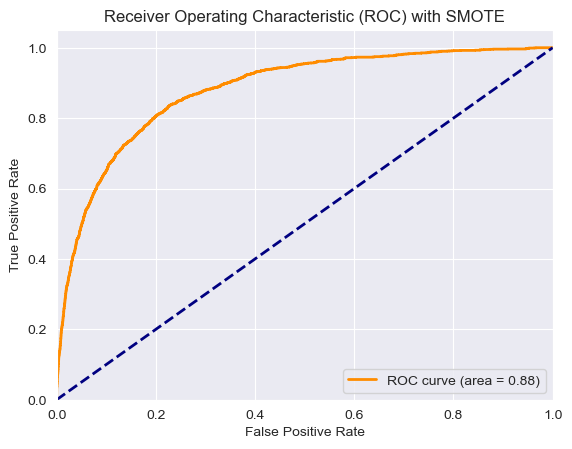

Average Precision Score with SMOTE: 0.5688


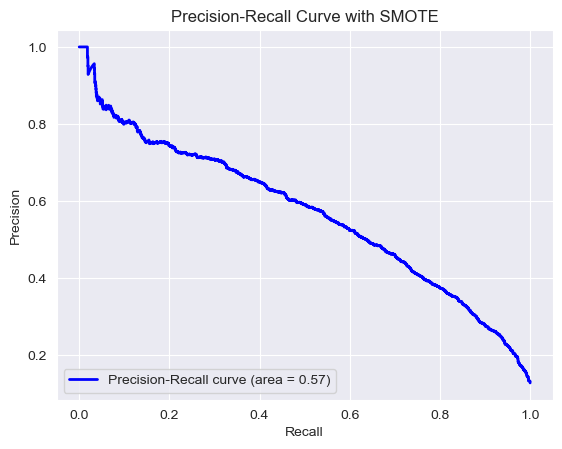

In [121]:
# Classification Report
print(f"Classification Report with SMOTE:\n {classification_report(y_test, y_pred_smote)}")

# ROC Curve and AUC Score
y_pred_proba_smote = grid_search_smote.predict_proba(X_test_selected)[:, 1]
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)
print(f"ROC-AUC Score with SMOTE: {roc_auc_smote:.4f}")

plt.figure()
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_smote:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) with SMOTE')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_pred_proba_smote)
average_precision_smote = average_precision_score(y_test, y_pred_proba_smote)
print(f"Average Precision Score with SMOTE: {average_precision_smote:.4f}")

plt.figure()
plt.plot(recall_smote, precision_smote, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision_smote:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with SMOTE')
plt.legend(loc="lower left")
plt.show()


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to 

Classification Report with Balanced Random Forest and ADASYN:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     13393
           1       0.58      0.53      0.55      1972

    accuracy                           0.89     15365
   macro avg       0.76      0.74      0.75     15365
weighted avg       0.89      0.89      0.89     15365

ROC-AUC Score with Balanced Random Forest and ADASYN: 0.8917


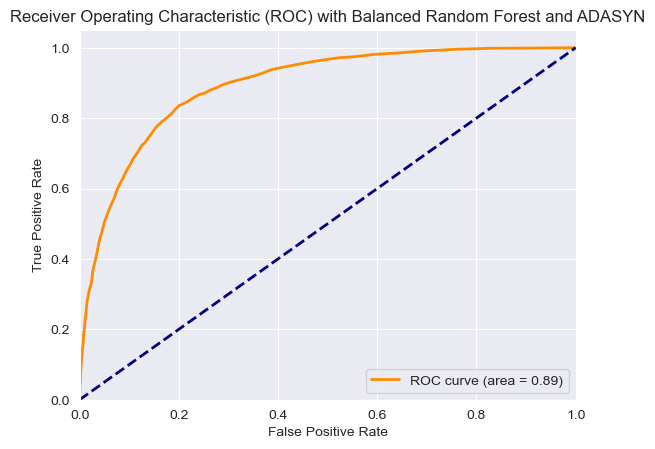

Average Precision Score with Balanced Random Forest and ADASYN: 0.5752


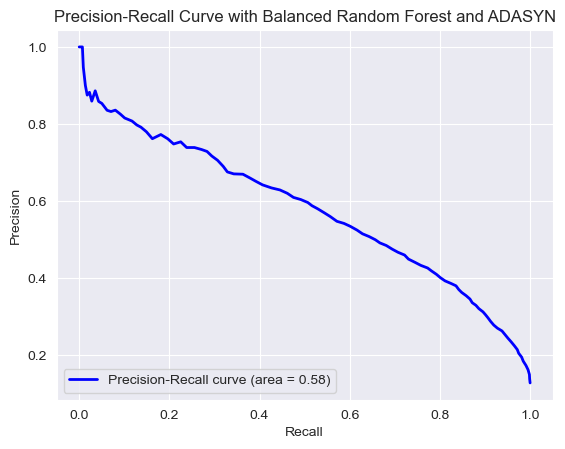

In [122]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

# Balanced Random Forest
brf_model = BalancedRandomForestClassifier(random_state=42, n_estimators=100)

# Train the Balanced Random Forest model
brf_model.fit(X_train_adasyn, y_train_adasyn)

# Predict on the test set
y_pred_brf = brf_model.predict(X_test_selected)
y_pred_proba_brf = brf_model.predict_proba(X_test_selected)[:, 1]

# Classification Report
print(f"Classification Report with Balanced Random Forest and ADASYN:\n {classification_report(y_test, y_pred_brf)}")

# ROC Curve and AUC Score
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_pred_proba_brf)
roc_auc_brf = auc(fpr_brf, tpr_brf)
print(f"ROC-AUC Score with Balanced Random Forest and ADASYN: {roc_auc_brf:.4f}")

plt.figure()
plt.plot(fpr_brf, tpr_brf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_brf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) with Balanced Random Forest and ADASYN')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_brf, recall_brf, _ = precision_recall_curve(y_test, y_pred_proba_brf)
average_precision_brf = average_precision_score(y_test, y_pred_proba_brf)
print(f"Average Precision Score with Balanced Random Forest and ADASYN: {average_precision_brf:.4f}")

plt.figure()
plt.plot(recall_brf, precision_brf, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision_brf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Balanced Random Forest and ADASYN')
plt.legend(loc="lower left")
plt.show()


Trying XGBoost

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/giocopp/miniconda3/envs/ML-Labs/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/gio

Best parameters with SMOTE and XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 1}
Best score with SMOTE and XGBoost: 0.9141783044204204
XGBoost Model Accuracy with SMOTE: 0.8981
Classification Report with SMOTE and XGBoost:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     13393
           1       0.63      0.50      0.56      1972

    accuracy                           0.90     15365
   macro avg       0.78      0.73      0.75     15365
weighted avg       0.89      0.90      0.89     15365

ROC-AUC Score with SMOTE and XGBoost: 0.9043


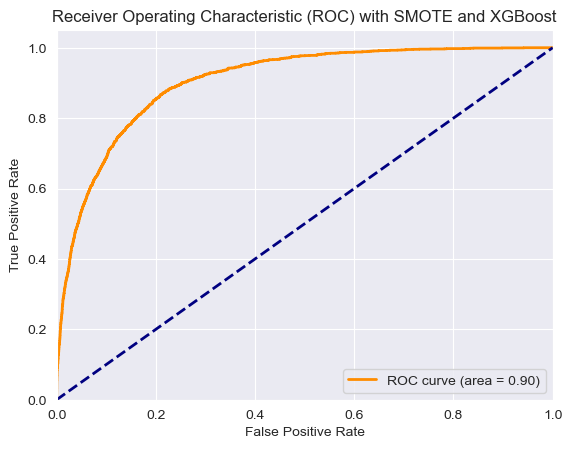

Average Precision Score with SMOTE and XGBoost: 0.6169


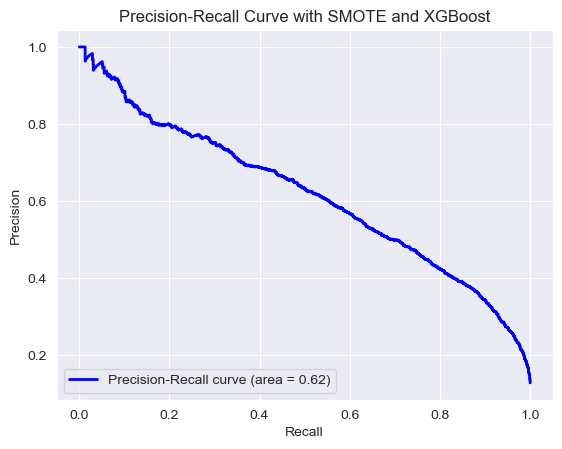

In [123]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, 5, 10]
}

# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train_smote, y_train_smote)

# Print the best parameters and score
print("Best parameters with SMOTE and XGBoost:", grid_search_xgb.best_params_)
print("Best score with SMOTE and XGBoost:", grid_search_xgb.best_score_)

# Predict on the test set
y_pred_xgb = grid_search_xgb.predict(X_test_selected)
y_pred_proba_xgb = grid_search_xgb.predict_proba(X_test_selected)[:, 1]

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy with SMOTE: {accuracy_xgb:.4f}")

# Classification Report
print(f"Classification Report with SMOTE and XGBoost:\n {classification_report(y_test, y_pred_xgb)}")

# ROC Curve and AUC Score
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"ROC-AUC Score with SMOTE and XGBoost: {roc_auc_xgb:.4f}")

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) with SMOTE and XGBoost')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
average_precision_xgb = average_precision_score(y_test, y_pred_proba_xgb)
print(f"Average Precision Score with SMOTE and XGBoost: {average_precision_xgb:.4f}")

plt.figure()
plt.plot(recall_xgb, precision_xgb, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with SMOTE and XGBoost')
plt.legend(loc="lower left")
plt.show()
